In [2]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

import tensorflow as tf

# keras
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

# sklearn (for machine learning)
from sklearn.model_selection import train_test_split

#confusion matrix stuff
from sklearn import metrics

In [3]:
#Loading the image data (X) and the associated labels (y)
X = np.load('trainingset_data.npy',allow_pickle=True)
y = [4,4,4,3,3,4,4,1,2,4,2,3,3,3,3,4,4,4,2,1,4,4,3,4,4,3,3,2,3,4,3,4,4,4,4,4,4,3,3,1,2,1,4,4,4,4,4,1,1,2,2,1,2,4,1,2,4,3,2,1,2,2,3,4,3,1,2,4,2,1,1,2,3,2,2,2,2,2,3,4,1,4,3,3,3,3,3,2,2,3,1,4,1,4,4,3,2,2,2,1,3,1,3,2,3,1,2,3,3,2,2,3,4,4,4,2,2,1,1,3,2,3,1,4,2,4,3,4,4,4,4,4,4,1,4,4,4,3,4,1,4,4,3,3,2,2,3,4,4,4,1,1,4,4,4,1,3,3,3,2,2,1,2,2,3,3,3,3,2,3,3,2,2,2,2,1,2,1,4,4,3,4,4,3,4,4,4,3,3,4,1,1,1,2,4,3,1,4,2,2,2,2,1,3,4,3,2,4,4,4,1,4,4,2,4,4,2,2,2,2,4,4,4,4,3,1,1,4,4,4,4,4,4,3,3,4,3,4,2,3,1,4,4,3,4,2,4,4,1,2,2,1,3,1,4,4,4,4,4,2,2,4,4,4,3,2,4,4,4,4,4,3,4,4,3,4,2,3,2,4,2]

#A check to make sure the dimensions of each list match
print(len(y),len(X))

281 281


Splitting the data into 70:10:20 ratio of train:validate:test

In [3]:
#Converting X and y into numpy arrays of floats       #randomstate 3 does pretty well
X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

#Converting our labels of 1,2,3,4 to 0,1,2,3 to be able to then make them 1hots
newy = []
for n in y:
    n = n-1
    newy.append(n)
    
#Converting labels to 1hots (vectors) eg. 0 becomes [1,0,0,0], 1 becomes [0,1,0,0] etc. 
y1hot = to_categorical(newy, dtype='float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y1hot, test_size=0.3, random_state=3, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=3, shuffle=True)

In [4]:
#In this cell the data is randomly rotated a multiple of 90 degrees
#Helps with the robustness of the network, since "up" has no meaning in this context

X_train_rot = []
for array in X_train:
    num = np.random.randint(0,4)
    if num == 0:
        newarray = np.rot90(array,1)
        X_train_rot.append(newarray)
    elif num == 1:
        newarray = np.rot90(array,2)
        X_train_rot.append(newarray)
    elif num == 2:
        newarray = np.rot90(array,3)
        X_train_rot.append(newarray)
    else:
        X_train_rot.append(array)
        
X_valid_rot = []
for array in X_valid:
    num = np.random.randint(0,4)
    if num == 0:
        newarray = np.rot90(array,1)
        X_valid_rot.append(newarray)
    elif num == 1:
        newarray = np.rot90(array,2)
        X_valid_rot.append(newarray)
    elif num == 2:
        newarray = np.rot90(array,3)
        X_valid_rot.append(newarray)
    else:
        X_valid_rot.append(array)
        
X_test_rot = []
for array in X_test:
    num = np.random.randint(0,4)
    if num == 0:
        newarray = np.rot90(array,1)
        X_test_rot.append(newarray)
    elif num == 1:
        newarray = np.rot90(array,2)
        X_test_rot.append(newarray)
    elif num == 2:
        newarray = np.rot90(array,3)
        X_test_rot.append(newarray)
    else:
        X_test_rot.append(array)
        
X_train = np.asarray(X_train_rot)
X_valid = np.asarray(X_valid_rot)
X_test = np.asarray(X_test_rot)

In [5]:
#Determines the image size of the data and reshapes to arrays into the correct format for the CNN

imsize = np.shape(X_train)[2]

X_train = X_train.reshape(-1, imsize, imsize, 1)
X_valid = X_valid.reshape(-1, imsize, imsize, 1)
X_test = X_test.reshape(-1, imsize, imsize, 1)

Building the CNN model architecture. The base structured is borrowed heavily from Section 3 of [Ciprijanovic et al. 2020](https://ui.adsabs.harvard.edu/abs/2020A%26C....3200390C/abstract) and the jupyter notebook written by Claire Murray Data Scientist, cmurray1@stsci.edu

Further details about Conv2D, MaxPooling2D, BatchNormalization, Dropout, and Dense layers can be found in the [Keras Layers Documentation](https://keras.io/api/layers/).  Further details about the sigmoid and softmax activation function can be found in the [Keras Activation Function Documentation](https://keras.io/api/layers/activations/).

In [6]:
# ------------------------------------------------------------------------------
# generate the model architecture
# Written for Keras 2
# ------------------------------------------------------------------------------

# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 1)

x_in = Input(shape=input_shape)

#a data augmentation layer, randomly flips the image
da0 = layers.RandomFlip('horizontal_and_vertical')(x_in)

c0 = Convolution2D(16, (5, 5), activation='relu', strides=(1, 1), padding='same')(da0)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
z2 = Dense(16, activation='softmax', kernel_regularizer=l2(0.0001))(z1)
y_out = Dense(4, activation='sigmoid')(z2)

model = Model(inputs=x_in, outputs=y_out)

In [7]:
#tf.keras.utils.plot_model(
#    model,
#    to_file='model.png',
#    show_shapes=True,
#    show_layer_names=True,
#    show_dtype=False,
#    rankdir='TB',
#    expand_nested=False,
#    dpi=96,
#    layer_range=None,
#    show_layer_activations=False
#)

In [8]:
#Compiles the model with appropriate optimizer, metrics and loss choices
#Provides a summary of the model

optimizer = 'adam'
metrics1 = ['accuracy']
loss = 'categorical_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=metrics1)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 1)]       0         
                                                                 
 random_flip (RandomFlip)    (None, 25, 25, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 25, 25, 16)        416       
                                                                 
 batch_normalization (BatchN  (None, 25, 25, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 16)        0     

### Train the CNN to perform a classification task

Train the model for a specified number of epochs. Overfitting is an issue when training goes on for too long.

You can learn more about model.fit [here](https://keras.rstudio.com/reference/fit.html)

In [9]:
nb_epoch = 2000
batch_size = 16
shuffle = True

# Train
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    validation_data=(X_valid, y_valid),                
                    shuffle=shuffle,
                    verbose=True)

Epoch 1/2000
13/13 [==============================] - 3s 59ms/step - loss: 1.4175 - accuracy: 0.2143 - val_loss: 1.3961 - val_accuracy: 0.3929
Epoch 2/2000
13/13 [==============================] - 0s 32ms/step - loss: 1.4063 - accuracy: 0.2143 - val_loss: 1.3904 - val_accuracy: 0.3929
Epoch 3/2000
13/13 [==============================] - 0s 30ms/step - loss: 1.3973 - accuracy: 0.2143 - val_loss: 1.3858 - val_accuracy: 0.3929
Epoch 4/2000
13/13 [==============================] - 0s 32ms/step - loss: 1.3890 - accuracy: 0.2143 - val_loss: 1.3815 - val_accuracy: 0.3929
Epoch 5/2000
13/13 [==============================] - 0s 28ms/step - loss: 1.3829 - accuracy: 0.3622 - val_loss: 1.3790 - val_accuracy: 0.2857
Epoch 6/2000
13/13 [==============================] - 0s 32ms/step - loss: 1.3765 - accuracy: 0.3980 - val_loss: 1.3771 - val_accuracy: 0.2857
Epoch 7/2000
13/13 [==============================] - 0s 30ms/step - loss: 1.3712 - accuracy: 0.3980 - val_loss: 1.3763 - val_accuracy: 0.2857

Epoch 58/2000
13/13 [==============================] - 0s 29ms/step - loss: 1.3227 - accuracy: 0.3980 - val_loss: 1.3934 - val_accuracy: 0.2857
Epoch 59/2000
13/13 [==============================] - 0s 28ms/step - loss: 1.3236 - accuracy: 0.3980 - val_loss: 1.3934 - val_accuracy: 0.2857
Epoch 60/2000
13/13 [==============================] - 0s 28ms/step - loss: 1.3220 - accuracy: 0.3980 - val_loss: 1.3907 - val_accuracy: 0.2857
Epoch 61/2000
13/13 [==============================] - 0s 27ms/step - loss: 1.3205 - accuracy: 0.3980 - val_loss: 1.3824 - val_accuracy: 0.2857
Epoch 62/2000
13/13 [==============================] - 0s 28ms/step - loss: 1.3200 - accuracy: 0.3980 - val_loss: 1.3824 - val_accuracy: 0.2857
Epoch 63/2000
13/13 [==============================] - 0s 27ms/step - loss: 1.3177 - accuracy: 0.3980 - val_loss: 1.3799 - val_accuracy: 0.2857
Epoch 64/2000
13/13 [==============================] - 0s 26ms/step - loss: 1.3193 - accuracy: 0.3980 - val_loss: 1.3793 - val_accuracy:

Epoch 115/2000
13/13 [==============================] - 0s 29ms/step - loss: 1.2087 - accuracy: 0.5102 - val_loss: 1.2543 - val_accuracy: 0.3929
Epoch 116/2000
13/13 [==============================] - 0s 29ms/step - loss: 1.2021 - accuracy: 0.4949 - val_loss: 1.2701 - val_accuracy: 0.3571
Epoch 117/2000
13/13 [==============================] - 0s 31ms/step - loss: 1.2114 - accuracy: 0.4796 - val_loss: 1.2686 - val_accuracy: 0.3929
Epoch 118/2000
13/13 [==============================] - 0s 32ms/step - loss: 1.1847 - accuracy: 0.5204 - val_loss: 1.2488 - val_accuracy: 0.3929
Epoch 119/2000
13/13 [==============================] - 0s 28ms/step - loss: 1.2106 - accuracy: 0.4847 - val_loss: 1.2172 - val_accuracy: 0.4286
Epoch 120/2000
13/13 [==============================] - 0s 26ms/step - loss: 1.1885 - accuracy: 0.5051 - val_loss: 1.2174 - val_accuracy: 0.4286
Epoch 121/2000
13/13 [==============================] - 0s 28ms/step - loss: 1.1929 - accuracy: 0.5102 - val_loss: 1.2243 - val_ac

13/13 [==============================] - 0s 35ms/step - loss: 1.1073 - accuracy: 0.5153 - val_loss: 1.2980 - val_accuracy: 0.3571
Epoch 228/2000
13/13 [==============================] - 0s 33ms/step - loss: 1.0865 - accuracy: 0.5561 - val_loss: 1.3007 - val_accuracy: 0.3571
Epoch 229/2000
13/13 [==============================] - 0s 33ms/step - loss: 1.1115 - accuracy: 0.5306 - val_loss: 1.2933 - val_accuracy: 0.3571
Epoch 230/2000
13/13 [==============================] - 0s 34ms/step - loss: 1.0755 - accuracy: 0.5357 - val_loss: 1.2697 - val_accuracy: 0.3571
Epoch 231/2000
13/13 [==============================] - 0s 35ms/step - loss: 1.1095 - accuracy: 0.5459 - val_loss: 1.2665 - val_accuracy: 0.3571
Epoch 232/2000
13/13 [==============================] - 0s 34ms/step - loss: 1.1221 - accuracy: 0.5204 - val_loss: 1.2914 - val_accuracy: 0.3571
Epoch 233/2000
13/13 [==============================] - 0s 35ms/step - loss: 1.0388 - accuracy: 0.5408 - val_loss: 1.2857 - val_accuracy: 0.3571


13/13 [==============================] - 0s 34ms/step - loss: 1.0589 - accuracy: 0.5255 - val_loss: 1.3306 - val_accuracy: 0.3214
Epoch 340/2000
13/13 [==============================] - 0s 33ms/step - loss: 1.0622 - accuracy: 0.5153 - val_loss: 1.3391 - val_accuracy: 0.3214
Epoch 341/2000
13/13 [==============================] - 0s 31ms/step - loss: 1.0531 - accuracy: 0.5306 - val_loss: 1.3197 - val_accuracy: 0.3214
Epoch 342/2000
13/13 [==============================] - 0s 31ms/step - loss: 1.0514 - accuracy: 0.5459 - val_loss: 1.3137 - val_accuracy: 0.3571
Epoch 343/2000
13/13 [==============================] - 0s 34ms/step - loss: 1.0634 - accuracy: 0.5510 - val_loss: 1.3347 - val_accuracy: 0.3214
Epoch 344/2000
13/13 [==============================] - 0s 35ms/step - loss: 1.0291 - accuracy: 0.5561 - val_loss: 1.3993 - val_accuracy: 0.3214
Epoch 345/2000
13/13 [==============================] - 0s 33ms/step - loss: 1.0526 - accuracy: 0.5306 - val_loss: 1.3695 - val_accuracy: 0.3214


13/13 [==============================] - 0s 34ms/step - loss: 1.0194 - accuracy: 0.5408 - val_loss: 1.3467 - val_accuracy: 0.3214
Epoch 452/2000
13/13 [==============================] - 0s 34ms/step - loss: 1.0546 - accuracy: 0.5459 - val_loss: 1.3320 - val_accuracy: 0.3214
Epoch 453/2000
13/13 [==============================] - 0s 34ms/step - loss: 1.0689 - accuracy: 0.5408 - val_loss: 1.3148 - val_accuracy: 0.3214
Epoch 454/2000
13/13 [==============================] - 0s 33ms/step - loss: 1.0113 - accuracy: 0.5459 - val_loss: 1.2710 - val_accuracy: 0.3214
Epoch 455/2000
13/13 [==============================] - 0s 33ms/step - loss: 1.0808 - accuracy: 0.5357 - val_loss: 1.2793 - val_accuracy: 0.3214
Epoch 456/2000
13/13 [==============================] - 0s 34ms/step - loss: 1.0350 - accuracy: 0.5561 - val_loss: 1.2974 - val_accuracy: 0.3571
Epoch 457/2000
13/13 [==============================] - 0s 34ms/step - loss: 1.0767 - accuracy: 0.5510 - val_loss: 1.3022 - val_accuracy: 0.2500


13/13 [==============================] - 0s 35ms/step - loss: 1.0447 - accuracy: 0.5459 - val_loss: 1.2987 - val_accuracy: 0.3214
Epoch 564/2000
13/13 [==============================] - 0s 33ms/step - loss: 1.0164 - accuracy: 0.5765 - val_loss: 1.2865 - val_accuracy: 0.2857
Epoch 565/2000
13/13 [==============================] - 0s 33ms/step - loss: 1.0267 - accuracy: 0.5153 - val_loss: 1.2638 - val_accuracy: 0.2857
Epoch 566/2000
13/13 [==============================] - 0s 34ms/step - loss: 1.0114 - accuracy: 0.5561 - val_loss: 1.2651 - val_accuracy: 0.3571
Epoch 567/2000
13/13 [==============================] - 0s 34ms/step - loss: 1.0385 - accuracy: 0.5204 - val_loss: 1.2963 - val_accuracy: 0.2857
Epoch 568/2000
13/13 [==============================] - 0s 34ms/step - loss: 0.9766 - accuracy: 0.5816 - val_loss: 1.3606 - val_accuracy: 0.2857
Epoch 569/2000
13/13 [==============================] - 0s 34ms/step - loss: 1.0098 - accuracy: 0.5459 - val_loss: 1.3453 - val_accuracy: 0.3214


13/13 [==============================] - 0s 36ms/step - loss: 0.9873 - accuracy: 0.5510 - val_loss: 1.3909 - val_accuracy: 0.2500
Epoch 676/2000
13/13 [==============================] - 0s 35ms/step - loss: 1.0530 - accuracy: 0.5510 - val_loss: 1.3907 - val_accuracy: 0.3571
Epoch 677/2000
13/13 [==============================] - 0s 35ms/step - loss: 1.0104 - accuracy: 0.5663 - val_loss: 1.3732 - val_accuracy: 0.3571
Epoch 678/2000
13/13 [==============================] - 0s 35ms/step - loss: 0.9797 - accuracy: 0.6020 - val_loss: 1.3750 - val_accuracy: 0.3214
Epoch 679/2000
13/13 [==============================] - 0s 35ms/step - loss: 0.9806 - accuracy: 0.5510 - val_loss: 1.3810 - val_accuracy: 0.3214
Epoch 680/2000
13/13 [==============================] - 0s 32ms/step - loss: 1.0250 - accuracy: 0.5255 - val_loss: 1.3883 - val_accuracy: 0.2857
Epoch 681/2000
13/13 [==============================] - 0s 34ms/step - loss: 0.9770 - accuracy: 0.5714 - val_loss: 1.4026 - val_accuracy: 0.2857


13/13 [==============================] - 0s 38ms/step - loss: 1.0129 - accuracy: 0.5510 - val_loss: 1.3381 - val_accuracy: 0.4286
Epoch 788/2000
13/13 [==============================] - 1s 42ms/step - loss: 0.9765 - accuracy: 0.6122 - val_loss: 1.3289 - val_accuracy: 0.3929
Epoch 789/2000
13/13 [==============================] - 0s 32ms/step - loss: 0.9655 - accuracy: 0.6276 - val_loss: 1.2974 - val_accuracy: 0.4286
Epoch 790/2000
13/13 [==============================] - 0s 35ms/step - loss: 0.9931 - accuracy: 0.6020 - val_loss: 1.3079 - val_accuracy: 0.4286
Epoch 791/2000
13/13 [==============================] - 0s 33ms/step - loss: 0.9450 - accuracy: 0.5867 - val_loss: 1.3177 - val_accuracy: 0.4643
Epoch 792/2000
13/13 [==============================] - 0s 33ms/step - loss: 0.9966 - accuracy: 0.5867 - val_loss: 1.3451 - val_accuracy: 0.4286
Epoch 793/2000
13/13 [==============================] - 0s 33ms/step - loss: 0.9804 - accuracy: 0.5867 - val_loss: 1.3676 - val_accuracy: 0.3929


13/13 [==============================] - 0s 34ms/step - loss: 0.9387 - accuracy: 0.6224 - val_loss: 1.2426 - val_accuracy: 0.5000
Epoch 900/2000
13/13 [==============================] - 0s 33ms/step - loss: 0.9619 - accuracy: 0.5867 - val_loss: 1.2496 - val_accuracy: 0.4643
Epoch 901/2000
13/13 [==============================] - 0s 35ms/step - loss: 0.9899 - accuracy: 0.6020 - val_loss: 1.2495 - val_accuracy: 0.5000
Epoch 902/2000
13/13 [==============================] - 0s 33ms/step - loss: 0.9469 - accuracy: 0.5969 - val_loss: 1.2600 - val_accuracy: 0.5000
Epoch 903/2000
13/13 [==============================] - 0s 34ms/step - loss: 0.9436 - accuracy: 0.5714 - val_loss: 1.2446 - val_accuracy: 0.5357
Epoch 904/2000
13/13 [==============================] - 0s 34ms/step - loss: 0.9193 - accuracy: 0.6122 - val_loss: 1.2758 - val_accuracy: 0.5000
Epoch 905/2000
13/13 [==============================] - 0s 34ms/step - loss: 0.9868 - accuracy: 0.5510 - val_loss: 1.2655 - val_accuracy: 0.4643


13/13 [==============================] - 0s 30ms/step - loss: 0.9313 - accuracy: 0.5918 - val_loss: 1.2987 - val_accuracy: 0.3571
Epoch 1012/2000
13/13 [==============================] - 0s 29ms/step - loss: 0.9267 - accuracy: 0.5663 - val_loss: 1.2977 - val_accuracy: 0.3571
Epoch 1013/2000
13/13 [==============================] - 0s 32ms/step - loss: 0.9783 - accuracy: 0.5663 - val_loss: 1.3055 - val_accuracy: 0.3214
Epoch 1014/2000
13/13 [==============================] - 0s 30ms/step - loss: 0.9799 - accuracy: 0.5867 - val_loss: 1.2856 - val_accuracy: 0.3214
Epoch 1015/2000
13/13 [==============================] - 0s 31ms/step - loss: 0.9997 - accuracy: 0.5612 - val_loss: 1.2719 - val_accuracy: 0.4286
Epoch 1016/2000
13/13 [==============================] - 0s 32ms/step - loss: 0.9414 - accuracy: 0.6531 - val_loss: 1.2810 - val_accuracy: 0.3929
Epoch 1017/2000
13/13 [==============================] - 0s 31ms/step - loss: 0.9342 - accuracy: 0.5918 - val_loss: 1.2740 - val_accuracy: 0

13/13 [==============================] - 0s 33ms/step - loss: 0.9441 - accuracy: 0.6173 - val_loss: 1.2071 - val_accuracy: 0.4643
Epoch 1124/2000
13/13 [==============================] - 0s 32ms/step - loss: 0.8876 - accuracy: 0.6582 - val_loss: 1.1949 - val_accuracy: 0.5000
Epoch 1125/2000
13/13 [==============================] - 0s 33ms/step - loss: 0.9492 - accuracy: 0.6327 - val_loss: 1.1794 - val_accuracy: 0.5000
Epoch 1126/2000
13/13 [==============================] - 0s 34ms/step - loss: 0.9350 - accuracy: 0.6173 - val_loss: 1.1802 - val_accuracy: 0.5357
Epoch 1127/2000
13/13 [==============================] - 0s 34ms/step - loss: 0.9017 - accuracy: 0.6837 - val_loss: 1.1925 - val_accuracy: 0.5000
Epoch 1128/2000
13/13 [==============================] - 0s 35ms/step - loss: 0.9563 - accuracy: 0.6480 - val_loss: 1.2041 - val_accuracy: 0.5000
Epoch 1129/2000
13/13 [==============================] - 0s 34ms/step - loss: 0.9597 - accuracy: 0.6224 - val_loss: 1.2039 - val_accuracy: 0

13/13 [==============================] - 0s 34ms/step - loss: 1.0052 - accuracy: 0.6173 - val_loss: 1.1744 - val_accuracy: 0.5714
Epoch 1236/2000
13/13 [==============================] - 0s 27ms/step - loss: 0.9767 - accuracy: 0.6071 - val_loss: 1.1804 - val_accuracy: 0.5714
Epoch 1237/2000
13/13 [==============================] - 0s 31ms/step - loss: 0.8819 - accuracy: 0.6939 - val_loss: 1.1806 - val_accuracy: 0.5714
Epoch 1238/2000
13/13 [==============================] - 0s 32ms/step - loss: 0.9843 - accuracy: 0.6582 - val_loss: 1.1839 - val_accuracy: 0.6071
Epoch 1239/2000
13/13 [==============================] - 0s 32ms/step - loss: 0.9334 - accuracy: 0.6582 - val_loss: 1.1865 - val_accuracy: 0.6071
Epoch 1240/2000
13/13 [==============================] - 0s 28ms/step - loss: 0.9355 - accuracy: 0.6633 - val_loss: 1.1927 - val_accuracy: 0.5714
Epoch 1241/2000
13/13 [==============================] - 0s 33ms/step - loss: 0.9189 - accuracy: 0.6582 - val_loss: 1.1947 - val_accuracy: 0

13/13 [==============================] - 0s 35ms/step - loss: 0.9680 - accuracy: 0.6224 - val_loss: 1.2727 - val_accuracy: 0.4286
Epoch 1348/2000
13/13 [==============================] - 0s 35ms/step - loss: 0.9778 - accuracy: 0.6020 - val_loss: 1.3025 - val_accuracy: 0.4286
Epoch 1349/2000
13/13 [==============================] - 0s 34ms/step - loss: 0.9582 - accuracy: 0.6378 - val_loss: 1.3033 - val_accuracy: 0.4286
Epoch 1350/2000
13/13 [==============================] - 0s 33ms/step - loss: 0.8874 - accuracy: 0.6735 - val_loss: 1.2865 - val_accuracy: 0.4286
Epoch 1351/2000
13/13 [==============================] - 0s 34ms/step - loss: 0.9142 - accuracy: 0.6020 - val_loss: 1.2825 - val_accuracy: 0.4286
Epoch 1352/2000
13/13 [==============================] - 0s 34ms/step - loss: 0.9818 - accuracy: 0.6122 - val_loss: 1.2832 - val_accuracy: 0.4286
Epoch 1353/2000
13/13 [==============================] - 0s 36ms/step - loss: 0.9469 - accuracy: 0.6684 - val_loss: 1.2764 - val_accuracy: 0

13/13 [==============================] - 0s 28ms/step - loss: 0.8708 - accuracy: 0.6378 - val_loss: 1.2702 - val_accuracy: 0.5357
Epoch 1460/2000
13/13 [==============================] - 0s 32ms/step - loss: 0.9093 - accuracy: 0.6276 - val_loss: 1.2880 - val_accuracy: 0.5000
Epoch 1461/2000
13/13 [==============================] - 0s 27ms/step - loss: 0.9177 - accuracy: 0.6633 - val_loss: 1.3009 - val_accuracy: 0.5000
Epoch 1462/2000
13/13 [==============================] - 0s 37ms/step - loss: 0.8823 - accuracy: 0.6684 - val_loss: 1.3098 - val_accuracy: 0.5000
Epoch 1463/2000
13/13 [==============================] - 0s 32ms/step - loss: 0.9396 - accuracy: 0.6378 - val_loss: 1.3080 - val_accuracy: 0.5357
Epoch 1464/2000
13/13 [==============================] - 0s 35ms/step - loss: 0.9101 - accuracy: 0.6327 - val_loss: 1.2926 - val_accuracy: 0.5357
Epoch 1465/2000
13/13 [==============================] - 0s 36ms/step - loss: 0.8723 - accuracy: 0.6429 - val_loss: 1.2922 - val_accuracy: 0

13/13 [==============================] - 0s 27ms/step - loss: 1.0047 - accuracy: 0.6480 - val_loss: 1.2567 - val_accuracy: 0.4643
Epoch 1572/2000
13/13 [==============================] - 0s 26ms/step - loss: 0.8328 - accuracy: 0.6939 - val_loss: 1.2725 - val_accuracy: 0.5000
Epoch 1573/2000
13/13 [==============================] - 0s 25ms/step - loss: 0.9696 - accuracy: 0.5918 - val_loss: 1.2816 - val_accuracy: 0.4643
Epoch 1574/2000
13/13 [==============================] - 0s 27ms/step - loss: 0.8931 - accuracy: 0.6480 - val_loss: 1.2936 - val_accuracy: 0.5000
Epoch 1575/2000
13/13 [==============================] - 0s 27ms/step - loss: 0.8913 - accuracy: 0.6582 - val_loss: 1.2935 - val_accuracy: 0.4643
Epoch 1576/2000
13/13 [==============================] - 0s 26ms/step - loss: 0.8953 - accuracy: 0.6939 - val_loss: 1.2876 - val_accuracy: 0.4286
Epoch 1577/2000
13/13 [==============================] - 0s 26ms/step - loss: 1.0169 - accuracy: 0.5765 - val_loss: 1.2805 - val_accuracy: 0

13/13 [==============================] - 0s 37ms/step - loss: 0.9485 - accuracy: 0.6378 - val_loss: 1.3399 - val_accuracy: 0.5000
Epoch 1684/2000
13/13 [==============================] - 0s 32ms/step - loss: 0.8411 - accuracy: 0.6633 - val_loss: 1.3391 - val_accuracy: 0.5000
Epoch 1685/2000
13/13 [==============================] - 0s 33ms/step - loss: 0.8596 - accuracy: 0.6837 - val_loss: 1.3371 - val_accuracy: 0.4643
Epoch 1686/2000
13/13 [==============================] - 0s 31ms/step - loss: 0.9388 - accuracy: 0.6429 - val_loss: 1.3257 - val_accuracy: 0.5000
Epoch 1687/2000
13/13 [==============================] - 0s 31ms/step - loss: 0.9455 - accuracy: 0.6378 - val_loss: 1.3307 - val_accuracy: 0.5000
Epoch 1688/2000
13/13 [==============================] - 0s 32ms/step - loss: 0.8741 - accuracy: 0.6582 - val_loss: 1.3272 - val_accuracy: 0.5000
Epoch 1689/2000
13/13 [==============================] - 0s 31ms/step - loss: 0.8904 - accuracy: 0.6735 - val_loss: 1.3303 - val_accuracy: 0

13/13 [==============================] - 0s 27ms/step - loss: 0.9231 - accuracy: 0.6582 - val_loss: 1.2770 - val_accuracy: 0.5714
Epoch 1796/2000
13/13 [==============================] - 0s 27ms/step - loss: 0.9080 - accuracy: 0.6327 - val_loss: 1.2991 - val_accuracy: 0.5357
Epoch 1797/2000
13/13 [==============================] - 0s 27ms/step - loss: 0.9072 - accuracy: 0.6582 - val_loss: 1.3171 - val_accuracy: 0.5714
Epoch 1798/2000
13/13 [==============================] - 0s 26ms/step - loss: 0.9441 - accuracy: 0.6480 - val_loss: 1.3820 - val_accuracy: 0.5000
Epoch 1799/2000
13/13 [==============================] - 0s 26ms/step - loss: 0.9002 - accuracy: 0.6276 - val_loss: 1.3857 - val_accuracy: 0.5357
Epoch 1800/2000
13/13 [==============================] - 0s 27ms/step - loss: 0.9132 - accuracy: 0.6684 - val_loss: 1.4015 - val_accuracy: 0.5000
Epoch 1801/2000
13/13 [==============================] - 0s 27ms/step - loss: 0.8307 - accuracy: 0.6531 - val_loss: 1.4023 - val_accuracy: 0

13/13 [==============================] - 0s 30ms/step - loss: 0.9126 - accuracy: 0.6327 - val_loss: 1.2819 - val_accuracy: 0.5000
Epoch 1908/2000
13/13 [==============================] - 0s 30ms/step - loss: 0.9023 - accuracy: 0.6582 - val_loss: 1.2900 - val_accuracy: 0.5000
Epoch 1909/2000
13/13 [==============================] - 0s 34ms/step - loss: 0.9026 - accuracy: 0.6531 - val_loss: 1.2915 - val_accuracy: 0.5357
Epoch 1910/2000
13/13 [==============================] - 0s 26ms/step - loss: 0.8314 - accuracy: 0.7041 - val_loss: 1.3041 - val_accuracy: 0.4643
Epoch 1911/2000
13/13 [==============================] - 0s 27ms/step - loss: 0.8292 - accuracy: 0.7194 - val_loss: 1.2975 - val_accuracy: 0.5000
Epoch 1912/2000
13/13 [==============================] - 0s 31ms/step - loss: 0.8573 - accuracy: 0.6480 - val_loss: 1.3097 - val_accuracy: 0.5000
Epoch 1913/2000
13/13 [==============================] - 0s 33ms/step - loss: 0.8083 - accuracy: 0.6684 - val_loss: 1.3351 - val_accuracy: 0

### Visualize CNN performance

To visualize the performance of the CNN, we plot the evolution of the accuracy and loss as a function of training epochs, for the training set and for the validation set.

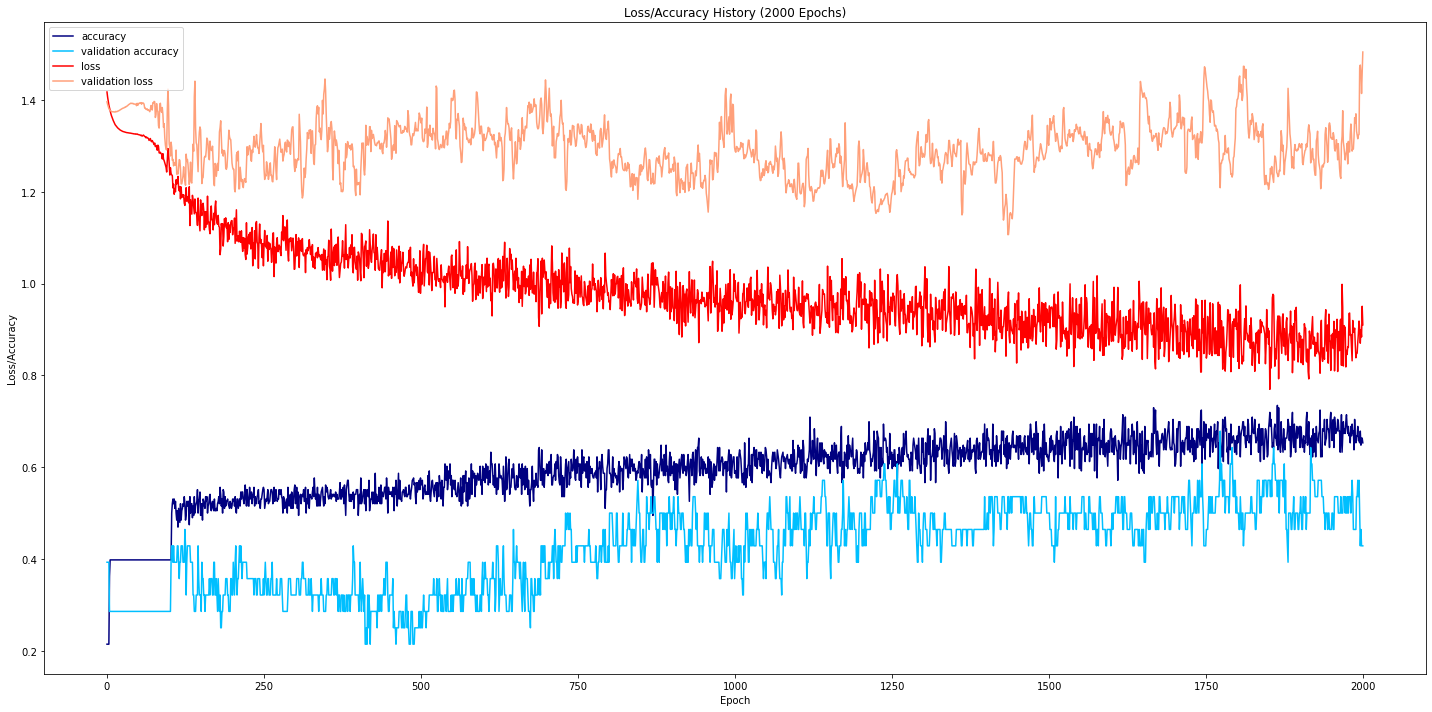

In [10]:
# plotting from history

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = list(range(len(loss)))
figsize=(20,10)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_lacc = axis1.plot(epochs, acc, 'navy', label='accuracy')
plot1_val_lacc = axis1.plot(epochs, val_acc, 'deepskyblue', label="validation accuracy")

plot1_loss = axis1.plot(epochs, loss, 'red', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'lightsalmon', label="validation loss")


plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss/Accuracy')
plt.title("Loss/Accuracy History (2000 Epochs)")
plt.tight_layout()

axis1.legend(loc='upper left')

In [11]:
#Uses the model to predict the labels of the test set

y_pred = model.predict(X_test)
print(y_pred)

[[0.41849875 0.72656035 0.555036   0.13953838]
 [0.1808446  0.3739962  0.5905784  0.5415553 ]
 [0.23301408 0.5183973  0.596903   0.3632825 ]
 [0.11495531 0.15384248 0.56211925 0.8301495 ]
 [0.09332979 0.07840937 0.5288742  0.92044485]
 [0.1148774  0.15263885 0.5614333  0.8315475 ]
 [0.10721368 0.12638736 0.5533408  0.8641028 ]
 [0.17190477 0.34469566 0.58817065 0.579472  ]
 [0.43665954 0.7307474  0.54648453 0.13386011]
 [0.09329888 0.07829842 0.52879184 0.9205691 ]
 [0.15498585 0.2879616  0.58284867 0.6542536 ]
 [0.27127856 0.5492262  0.57949126 0.31833377]
 [0.29183453 0.5882971  0.5790706  0.275863  ]
 [0.48587307 0.7541761  0.5293145  0.11221665]
 [0.46639305 0.7449982  0.5360427  0.12044409]
 [0.21537286 0.4539399  0.58877844 0.43671948]
 [0.0952298  0.08512363 0.53353304 0.912866  ]
 [0.10149917 0.10713813 0.5457023  0.88730776]
 [0.45029318 0.7371212  0.5415798  0.12770024]
 [0.8474865  0.7805929  0.30296904 0.05518964]
 [0.44319367 0.7410997  0.54739606 0.12627226]
 [0.23366174 

In [12]:
#Converts the y1hot vectors back into integers 
#These will still be 0,1,2,3 at this point

ytestint = np.argmax(y_test,axis=1)
print(ytestint)

ypredint = np.argmax(y_pred,axis=1)
print(ypredint)

[2 3 0 3 1 3 3 3 2 3 3 1 1 1 0 1 3 1 1 0 1 1 2 3 3 1 3 2 0 3 3 2 0 1 2 1 3
 1 2 3 3 1 2 0 3 3 3 1 3 1 3 3 3 2 2 2 2]
[1 2 2 3 3 3 3 2 1 3 3 2 1 1 1 2 3 3 1 0 1 2 2 2 3 1 3 2 2 2 2 3 1 3 1 2 2
 1 2 3 2 1 2 0 3 1 2 2 3 0 3 3 3 3 3 3 1]


In [13]:
#Confusion matrix comparing the predicted labels to the known labels
#Known labels are shown in the rows, predicted labels are the columns

print(metrics.confusion_matrix(ytestint,ypredint))

[[ 2  2  2  0]
 [ 1  7  5  3]
 [ 0  4  4  4]
 [ 0  1  8 14]]


In [14]:
#Simple way to show the accuracy of the model on the test set

count = 0
for num,num1 in zip(ytestint,ypredint):
    if num == num1:
        count +=1
        
print("The test set accuracy is {:2.2f}% for this model".format((count/len(ytestint))*100))

The test set accuracy is 47.37% for this model


In [26]:
#Loads all the objects of interest identified by source extractor for classification
#Uses the trained CNN to predict the labels

m12i_all = np.load('all_clusters_data.npy',allow_pickle=True)
m12i_pred = model.predict(m12i_all)

In [27]:
#Converts the 1hot vectors to integers and adds 1 to each so that the labels are again 1,2,3,4 for convenience

m12i_class_pre = np.argmax(m12i_pred,axis=1)
m12i_class = []
for n in m12i_class_pre:
    num = n + 1
    m12i_class.append(num)

In [28]:
class1 = m12i_class.count(1)
class2 = m12i_class.count(2)
class3 = m12i_class.count(3)
class4 = m12i_class.count(4)

print('Class 1: '+str(class1))
print('Class 2: '+str(class2))
print('Class 3: '+str(class3))
print('Class 4: '+str(class4))

Class 1: 1754
Class 2: 6501
Class 3: 12453
Class 4: 14640


In [18]:
m12i_class_array = np.array(m12i_class)

indices = np.where(m12i_class_array == 1)
class1_index_list = list(indices[0])
print(len(class1_index_list))

1754


In [19]:
randints = np.random.randint(len(class1_index_list),size=10)
indexs = []
for n in randints:
    indexs.append(class1_index_list[n])
print(indexs)

[10216, 27018, 26946, 32914, 22425, 9860, 19745, 21166, 20555, 21398]


In [20]:
m12i_class_array = np.array(m12i_class)

indices = np.where(m12i_class_array == 2)
class2_index_list = list(indices[0])
print(len(class2_index_list))

6501


In [21]:
m12i_class_array = np.array(m12i_class)

indices = np.where(m12i_class_array == 3)
class3_index_list = list(indices[0])
print(len(class3_index_list))

12453


In [22]:
m12i_class_array = np.array(m12i_class)

indices = np.where(m12i_class_array == 4)
class4_index_list = list(indices[0])
print(len(class4_index_list))

14640


In [23]:
#from sklearn.model_selection import StratifiedKFold

In [24]:
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
#cvscores = []

In [25]:
#for train,test in kfold.split(X,newy):
#    y1hot = to_categorical(newy, dtype='float32')
#    model.fit(X[train], y1hot[train],
#                    batch_size=batch_size,
#                    epochs=2000,                
#                    shuffle=shuffle,
#                    verbose=True)
#    scores = model.evaluate(X[test], y1hot[test], verbose=True)
#    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
#    cvscores.append(scores[1] * 100)
#print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))